In [46]:
import numpy as np
import seaborn as sns
from db.DataAccessObject import DataAccessObject
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression
import pickle

In [35]:
PATH = "./analysis/"
IMG_PATH = "./analysis/"

In [3]:
# Preparing data and trained models.
nn_gender = pickle.load(open(PATH + "nn_gender.dat", "rb"))
nn_age = pickle.load(open(PATH + "nn_age.dat", "rb"))
nn_ethnicity = pickle.load(open(PATH + "nn_ethnicity.dat", "rb"))

dataset = DataAccessObject(database="local", collection="grayscale")
cursor = dataset.get_X_y_pair(20000, 0, **{"gender": True, "age": True, "ethnicity": True})

X = []
y_gender = []
y_age = []
y_ethnicity = []

for raw_data in cursor:
    X.append(raw_data["pixels"])
    y_gender.append(raw_data["gender"])
    y_age.append(raw_data["age"])
    y_ethnicity.append(raw_data["ethnicity"])

X = np.array(X)

y_hat_gender_label = nn_gender.predict(X)

y_hat_gender = nn_gender.predict(X)
y_hat_age = nn_age.predict(X)
y_hat_ethnicity = nn_ethnicity.predict(X)

In [20]:
# Confusion matrix and heatmap.
def confusion_matrix(y_hat, y_truth, criterion):
    """Function that returns the confusion matrix of the given data set."""
    tp = tn = fp = fn = 0
    # Calculate for True Positive
    for idx in range(len(y_hat)):
        if y_truth[idx] == criterion:
            if y_hat[idx] == y_truth[idx]:
                tp += 1
            else:
                fp += 1
        else:
            if y_hat[idx] == y_truth[idx]:
                tn += 1
            else:
                fn += 1

    print(f"----- Confusion Matrix -----")
    print(f"True Negative: {tn} False Positive: {fp}")
    print(f"False Negative: {fn} True Positive: {tp}")
    return tp, fp, tn, fn

In [39]:
def plot_confusion_matrix(true_negative, false_positive, false_negative, true_positive, axis_labels=[]):
    total = true_positive + false_positive
    data = np.array([[true_negative, false_positive], [false_negative, true_positive]])
    labels = np.asarray([f"True Neg\n{true_negative}\n{true_negative / total:.2%}",
                         f"False Pos\n{false_positive}\n{false_positive / total:.2%}",
                         f"False Neg\n{false_negative}\n{false_negative / total:.2%}",
                         f"True Pos\n{true_positive}\n{true_positive / total:.2%}"]
                        ).reshape((2, 2))
    fig = sns.heatmap(data, annot=labels, xticklabels=axis_labels, yticklabels=axis_labels,
                      fmt="", cmap="Blues").get_figure()
    fig.savefig(IMG_PATH + "confusion_matrix.png")

In [40]:
# Calculate for McFadden's pseudo R-squared
def logit(x, w):
    return 1 / (1 + np.exp(-np.dot(x, w.T)))


def log_likelihood(w, X, y):
    """Function that calculates for the log-likelihood given weight, X, and y."""
    ll = 0
    for idx in range(len(y)):
        proba = np.power(logit(X[idx], w), y[idx]) + np.power((1 - logit(X[idx], w)), 1 - y[idx])
        ll += proba
    return ll


def mcfadden_rsquared(trained_weight, null_weight, X, y):
    trained_log_likelihood = log_likelihood(trained_weight, X, y)
    null_log_likelihood = log_likelihood(null_weight, X, y)
    return 1.0 - (trained_log_likelihood / null_log_likelihood)

In [41]:
# ROC-AUC Curve
def plot_roc(nn: LogisticRegression, X, y_truth, pos_label, title):
    # Calculate for score of this model based on X.
    y_predicted_prob = nn.predict_proba(X)
    y_predicted_prob = np.array([p[0] for p in y_predicted_prob])
    fpr, tpr, threshold = roc_curve(y_truth, y_predicted_prob, pos_label=pos_label)
    roc_auc = roc_auc_score([1 if p == pos_label else 0 for p in y_truth], y_predicted_prob)
    roc_plot = sns.lineplot(x="False Positive Rate", y="True Positive Rate", data={"False Positive Rate": fpr, "True Positive Rate": tpr})
    roc_plot.set_title(title + f"\nAUC: {roc_auc}")
    roc_plot.set_xlabel("False Positive Rate")
    roc_plot.set_ylabel("True Positive Rate")
    fig = roc_plot.get_figure()
    fig.savefig(IMG_PATH + f"{title}.png")

----- Confusion Matrix -----
True Negative: 11440 False Positive: 241
False Negative: 311 True Positive: 8008


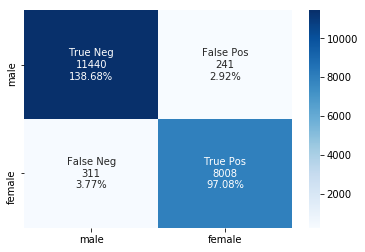

In [42]:
# Plot confusion matrix.
true_positive, false_positive, true_negative, false_negative = confusion_matrix(y_hat_gender, y_gender, "female")
plot_confusion_matrix(true_negative, false_positive, false_negative, true_positive, ["male", "female"])

In [43]:
# Compute pseudo r-squared
y_numeric = [0 if g == "male" else 1 for g in y_gender]
null_weight = np.array([1.0 if i == 0 else 0.0 for i in range(X.shape[1])])
print(f"McFadden's pseudo R-squared: {mcfadden_rsquared(nn_gender.coef_, null_weight, X, y_numeric)[0]}")
# value from 0.2-0.4 is excellent fit!!

McFadden's pseudo R-squared: 0.31467801021392716


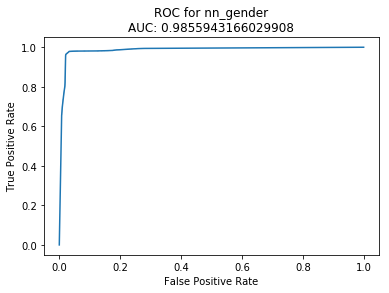

In [44]:
# Create ROC
plot_roc(nn_gender, X, y_gender, pos_label="female", title="ROC for nn_gender")

In [45]:
# Model Report
print(classification_report(y_gender, y_hat_gender))

              precision    recall  f1-score   support

      female       0.96      0.97      0.97      8249
        male       0.98      0.97      0.98     11751

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

